In this notebook we'll use the open bandit pipeline

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression
# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LinearRegression

# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression
# import open bandit pipeline (obp)
from obp.dataset import SyntheticBanditDataset
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPW,
    DirectMethod as DM,
    DoublyRobust as DR,
)


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import obp
from obp.dataset import OpenBanditDataset
from obp.policy import IPWLearner, NNPolicyLearner
from obp.ope import (
    RegressionModel,
    OffPolicyEvaluation,
    SelfNormalizedInverseProbabilityWeighting as SNIPS,
    DoublyRobust as DR,
)

We will unload the picke files

In [10]:
import pickle 


In [11]:
with open('saved_bdf_dic_train.pkl', 'rb') as f:
    bdf_feedback_train_k = pickle.load(f)
    
    

        

In [13]:
with open('saved_bdf_dic_test.pkl', 'rb') as f:
    bdf_feedback_test_k = pickle.load(f)
    
    


In [33]:
for k in np.arange(0.1,1.5,0.3):
    bdf_feedback_test_k[np.around(k,decimals=1)]=bdf_feedback_test_k[k]
    bdf_feedback_train_k[np.around(k,decimals=1)]=bdf_feedback_train_k[k]

some quantities needed to be of type float

In [16]:
l=['expected_reward','pi_b','pscore']
for k in np.arange(0.1,1.5,0.3):
    
    for j in l:

        bdf_feedback_train_k[k][j]=bdf_feedback_train_k[k][j].astype(float)
        bdf_feedback_test_k[k][j]=bdf_feedback_test_k[k][j].astype(float)

This is the step of off policy learning we create a class to  have an estimate $$\hat{V}(\pi;D_0)$$ of $$V(\pi,D_0)$$ to find the argmax on the space of policy

The base classifier is the ML classifier used to train an offline decision making policy

In [17]:
eval_policy = IPWLearner(n_actions=85, base_classifier=LogisticRegression())

The OPE is chosen method to evaluate our new policy

In [83]:

eval_policy.fit(
    context=bdf_feedback_train["context"],
    action=bdf_feedback_train["action"],
    reward=bdf_feedback_train["reward"],
    pscore=bdf_feedback_train["pscore"]
)
action_dist = eval_policy.predict(context=bdf_feedback_test["context"])


ope = OffPolicyEvaluation(
    bandit_feedback=bdf_feedback_test,
    ope_estimators=[IPW(), DM(), DR()]
)

/opt/homebrew/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In the case we use a model base approach we can have a an ML algorithm to predict the reward

In [84]:
# (3) Off-Policy Evaluation
regression_model = RegressionModel(
    n_actions=85,
    base_model=LinearRegression(),
)
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bdf_feedback_test["context"],
    action=bdf_feedback_test["action"],
    reward=bdf_feedback_test["reward"],
)

A way to visualize the estimation of V(pi) 

/Users/samuelgirard/zr-obp/obp/ope/meta.py:640: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95.0)` for the same effect.

  sns.barplot(


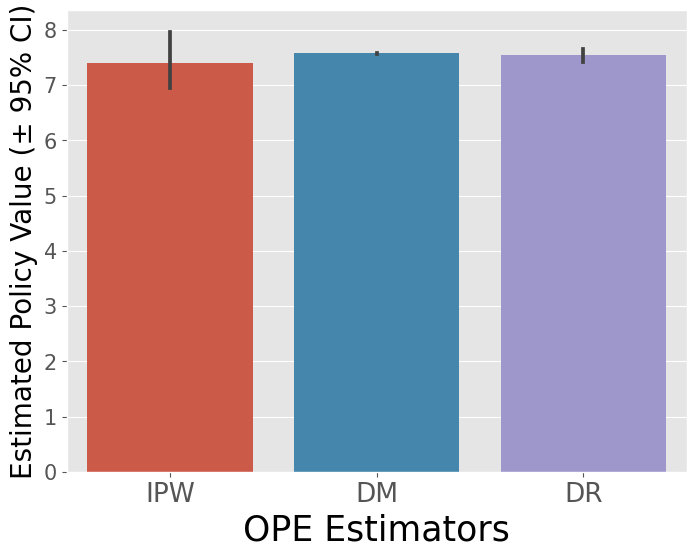

In [85]:
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
)



In [11]:
from obp.ope import SelfNormalizedInverseProbabilityWeighting

In [12]:
from obp.policy import QLearner

In [12]:
from obp.policy import NNPolicyLearner

In [58]:
nnpol=NNPolicyLearner(n_actions=112,dim_context=1,off_policy_objective='ipw-subgauss')

In [59]:
nnpol.fit(context=bdf_feedback_train["context"],
    action=bdf_feedback_train["action"],
    reward=bdf_feedback_train["reward"],
    pscore=bdf_feedback_train["pscore"])

policy learning: 100%|████████████████████████| 200/200 [48:15<00:00, 14.48s/it]


In [62]:
nn_dist=nnpol.predict(bdf_feedback_test["context"])

In [13]:
ac_opt=np.zeros((len(bdf_feedback_test['context']),85,1))
ma=bdf_feedback_test['expected_reward'].argmax(1)
for j in range(len(bdf_feedback_test['context'])):
    ac_opt[j,ma[j],None]=1


In [14]:
#evaluation policy with different estimators
qlearner=QLearner(n_actions=85,base_model=LinearRegression())
eval_policy = IPWLearner(n_actions=85, base_classifier=LogisticRegression())
eval_policy_rf = IPWLearner(
    n_actions=85,
    base_classifier=RandomForestClassifier(
        n_estimators=100, max_depth=5, min_samples_leaf=10, random_state=12345
    ),
)
qlearner.fit(
    context=bdf_feedback_train["context"],
    action=bdf_feedback_train["action"],
    reward=bdf_feedback_train["reward"],
    pscore=bdf_feedback_train["pscore"]
)
eval_policy.fit(
    context=bdf_feedback_train["context"],
    action=bdf_feedback_train["action"],
    reward=bdf_feedback_train["reward"],
    pscore=bdf_feedback_train["pscore"]
)
eval_policy_rf.fit(
    context=bdf_feedback_train["context"],
    action=bdf_feedback_train["action"],
    reward=bdf_feedback_train["reward"],
    pscore=bdf_feedback_train["pscore"]
)

#obtaining the new policy
qlearner_dist=qlearner.predict(bdf_feedback_test["context"])
eval_policy_dist=eval_policy.predict(bdf_feedback_test["context"])
eval_policy_rf_dist=eval_policy_rf.predict(bdf_feedback_test["context"])
optimal_dist=ac_opt


/opt/homebrew/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
ipw=IPW()
dm=DM()
dr=DR()

In [19]:
v_df.loc['policy_of_IPW_random_forest','IPW_estimator']=ipw.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=eval_policy_rf_dist)

v_df.loc['policy_of_IPW_logistic_regression','IPW_estimator']=ipw.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=eval_policy_dist)

v_df.loc['policy_of_DM','IPW_estimator']=ipw.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=qlearner_dist)

v_df.loc['optimal_policy','IPW_estimator']=ipw.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=optimal_dist)
v_df.loc['behavior_policy','IPW_estimator']=ipw.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=bdf_feedback_test["pi_b"])



In [18]:

v_df.loc['policy_of_IPW_random_forest','DR_estimator']=dr.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=eval_policy_rf_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)

v_df.loc['policy_of_IPW_logistic_regression','DR_estimator']=dr.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=eval_policy_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)

v_df.loc['policy_of_DM','DR_estimator']=dr.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=qlearner_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)

v_df.loc['optimal_policy','DR_estimator']=dr.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=optimal_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)
v_df.loc['behavior_policy','DR_estimator']=dr.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=bdf_feedback_test["pi_b"],estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)



In [20]:

v_df.loc['policy_of_IPW_random_forest','DM_estimator']=dm.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=eval_policy_rf_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)

v_df.loc['policy_of_IPW_logistic_regression','DM_estimator']=dm.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=eval_policy_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)

v_df.loc['policy_of_DM','DM_estimator']=dm.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=qlearner_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)

v_df.loc['optimal_policy','DM_estimator']=dm.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=optimal_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)
v_df.loc['behavior_policy','DM_estimator']=dm.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=bdf_feedback_test["pi_b"],estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)



In [21]:

v_df.loc['policy_of_IPW_random_forest','ground_truth']=np.average(bdf_feedback_test["expected_reward"], weights=eval_policy_rf_dist[:, :, 0], axis=1).mean()
v_df.loc['policy_of_IPW_logistic_regression','ground_truth']=np.average(bdf_feedback_test["expected_reward"], weights=eval_policy_dist[:, :, 0], axis=1).mean()
v_df.loc['policy_of_DM','ground_truth']=np.average(bdf_feedback_test["expected_reward"], weights=qlearner_dist[:, :, 0], axis=1).mean()
v_df.loc['optimal_policy','ground_truth']=np.average(bdf_feedback_test["expected_reward"], weights=optimal_dist[:, :, 0], axis=1).mean()
v_df.loc['behavior_policy','ground_truth']=np.average(bdf_feedback_test["expected_reward"], weights=bdf_feedback_test["pi_b"][:,:,0], axis=1).mean()


In [17]:
v_df=pd.DataFrame(index=['policy_of_IPW_random_forest','policy_of_IPW_logistic_regression','policy_of_DM',
                               'optimal_policy','behavior_policy'],columns=['IPW_estimator','DM_estimator','DR_estimator','ground_truth'])


In [20]:
import pickle 

with open('v_df.pkl', 'wb') as f:
    pickle.dump(v_df, f)

In [25]:
k_good=pd.DataFrame(index=['IPW', 'Optimal','Behavior','ground_truth'],columns=['0.1', '0.4', '0.7', '1.', '1.3'])

In [34]:

eval_policy_01 = IPWLearner(n_actions=85, base_classifier=LogisticRegression())
eval_policy_04= IPWLearner(n_actions=85, base_classifier=LogisticRegression())
eval_policy_07= IPWLearner(n_actions=85, base_classifier=LogisticRegression())
eval_policy_1= IPWLearner(n_actions=85, base_classifier=LogisticRegression())
eval_policy_13= IPWLearner(n_actions=85, base_classifier=LogisticRegression())

eval_policy_01.fit(
    context=bdf_feedback_train_k[0.1]["context"],
    action=bdf_feedback_train_k[0.1]["action"],
    reward=bdf_feedback_train_k[0.1]["reward"],
    pscore=bdf_feedback_train_k[0.1]["pscore"]
)

eval_policy_04.fit(
    context=bdf_feedback_train_k[0.4]["context"],
    action=bdf_feedback_train_k[0.4]["action"],
    reward=bdf_feedback_train_k[0.4]["reward"],
    pscore=bdf_feedback_train_k[0.4]["pscore"]
)

eval_policy_07.fit(
    context=bdf_feedback_train_k[0.7]["context"],
    action=bdf_feedback_train_k[0.7]["action"],
    reward=bdf_feedback_train_k[0.7]["reward"],
    pscore=bdf_feedback_train_k[0.7]["pscore"]
)
eval_policy_1.fit(
    context=bdf_feedback_train_k[1]["context"],
    action=bdf_feedback_train_k[1]["action"],
    reward=bdf_feedback_train_k[1]["reward"],
    pscore=bdf_feedback_train_k[1]["pscore"]
)
eval_policy_13.fit(
    context=bdf_feedback_train_k[1.3]["context"],
    action=bdf_feedback_train_k[1.3]["action"],
    reward=bdf_feedback_train_k[1.3]["reward"],
    pscore=bdf_feedback_train_k[1.3]["pscore"]
)
eval_policy_dist_01=eval_policy_01.predict(bdf_feedback_test_k[0.1]["context"])
eval_policy_dist_04=eval_policy_04.predict(bdf_feedback_test_k[0.4]["context"])
eval_policy_dist_07=eval_policy_07.predict(bdf_feedback_test_k[0.7]["context"])
eval_policy_dist_1=eval_policy_1.predict(bdf_feedback_test_k[1]["context"])
eval_policy_dist_13=eval_policy_13.predict(bdf_feedback_test_k[1.3]["context"])
ipw=IPW()

k_good.loc['IPW','0.1']=ipw.estimate_policy_value(reward=bdf_feedback_test_k[0.1]["reward"],
                                  action=bdf_feedback_test_k[0.1]["action"],pscore=bdf_feedback_test_k[0.1]["pscore"],
                                  action_dist=eval_policy_dist_01)
k_good.loc['IPW','0.4']=ipw.estimate_policy_value(reward=bdf_feedback_test_k[0.4]["reward"],
                                  action=bdf_feedback_test_k[0.4]["action"],pscore=bdf_feedback_test_k[0.4]["pscore"],
                                  action_dist=eval_policy_dist_04)
k_good.loc['IPW','0.7']=ipw.estimate_policy_value(reward=bdf_feedback_test_k[0.7]["reward"],
                                  action=bdf_feedback_test_k[0.7]["action"],pscore=bdf_feedback_test_k[0.7]["pscore"],
                                  action_dist=eval_policy_dist_07)
k_good.loc['IPW','1.']=ipw.estimate_policy_value(reward=bdf_feedback_test_k[1]["reward"],
                                  action=bdf_feedback_test_k[1]["action"],pscore=bdf_feedback_test_k[1]["pscore"],
                                  action_dist=eval_policy_dist_1)
k_good.loc['IPW','1.3']=ipw.estimate_policy_value(reward=bdf_feedback_test_k[1.3]["reward"],
                                  action=bdf_feedback_test_k[1.3]["action"],pscore=bdf_feedback_test_k[1.3]["pscore"],
                                  action_dist=eval_policy_dist_13)
k_good.loc['ground_truth','0.1']=np.average(bdf_feedback_test_k[0.1]["expected_reward"], weights=eval_policy_dist_01[:, :, 0], axis=1).mean()
k_good.loc['ground_truth','0.4']=np.average(bdf_feedback_test_k[0.4]["expected_reward"], weights=eval_policy_dist_04[:, :, 0], axis=1).mean()
k_good.loc['ground_truth','0.7']=np.average(bdf_feedback_test_k[0.7]["expected_reward"], weights=eval_policy_dist_07[:, :, 0], axis=1).mean()
k_good.loc['ground_truth','1.']=np.average(bdf_feedback_test_k[1]["expected_reward"], weights=eval_policy_dist_1[:, :, 0], axis=1).mean()
k_good.loc['ground_truth','1.3']=np.average(bdf_feedback_test_k[1.3]["expected_reward"], weights=eval_policy_dist_13[:, :, 0], axis=1).mean()


/opt/homebrew/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

In [35]:
k_good

,ground truth,0.1,0.4,0.7,1.,1.3
IPW,NaN,0.0,5.49503,5.526629,5.444358,5.353072
Optimal,NaN,NaN,NaN,NaN,NaN,NaN
Behavior,NaN,NaN,NaN,NaN,NaN,NaN
ground_truth,NaN,0.0,0.296942,0.412947,0.52071,0.581218


In [23]:
a=ipw._estimate_round_rewards(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=eval_policy_dist)

array([  0.        , 104.26213919,  46.0971604 , ...,   0.        ,
         0.        ,   0.        ])

We're looking for a way to visualize the estimated reward from the regression model to see how it compares with the real expected reward

In [28]:
gamma=bdf_feedback_test["context"].reshape(-1,)



In [29]:
np.sort(gamma)

array([-7. , -6.8, -6.6, ...,  5.2,  5.4,  5.4])

In [28]:
estim=regression_model.fit_predict(
    context=bdf_feedback_train["context"],
    action=bdf_feedback_train["action"],
    reward=bdf_feedback_train["reward"],
)

In [34]:
import seaborn as sns

In [30]:
qzzz=pd.Series(gamma).drop_duplicates().sort_values().index.values




In [32]:
ws=pd.DataFrame(index=pd.Series(gamma).drop_duplicates().sort_values().values,data=estimated_rewards_by_reg_model[:,:,0][qzzz,:],columns=np.arange(1,86))

Text(50.722222222222214, 0.5, 'theta')

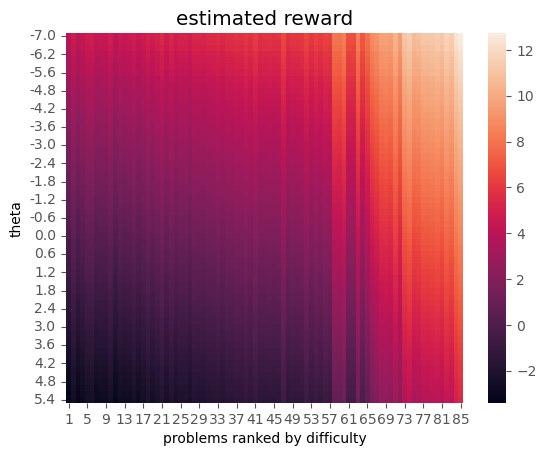

In [35]:
sns.heatmap(ws.astype(float))
plt.title('estimated reward')
plt.xlabel('problems ranked by difficulty')
plt.ylabel('theta')


In [36]:

prob_mat_dist=pd.DataFrame(index=pd.Series(gamma).drop_duplicates().sort_values().values,columns=np.arange(1,86))

In [40]:
prob_mat_dist

,1,2,3,4,5,6,7,8,9,10,...,76,77,78,79,80,81,82,83,84,85
-7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-6.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
len(bdf_feedback_test['context'])
qlearner_dist=qlearner.predict(bdf_feedback_test["context"])
eval_policy_dist=eval_policy.predict(bdf_feedback_test["context"])
eval_policy_rf_dist=eval_policy_rf.predict(bdf_feedback_test["context"])
optimal_dist=ac_opt


94318

In [42]:
eval_policy_rf_dist.shape

(94318, 85, 1)

We're visualizing how the new found policy looks

In [54]:
prob_mat_dist.loc[:,:]=optimal_dist.reshape(len(bdf_feedback_test['context']), 85)[qzzz]

Text(0.5, 23.52222222222222, 'problems')

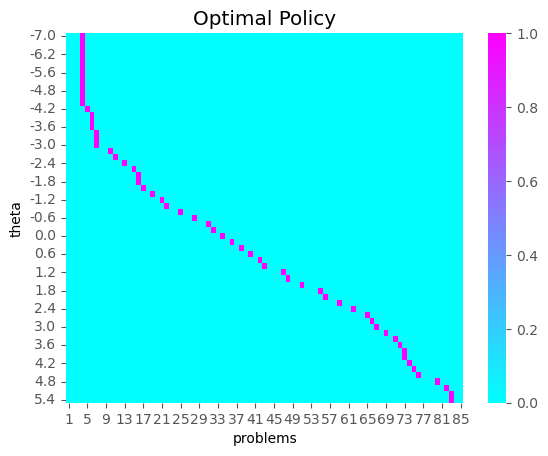

In [55]:
sns.heatmap(prob_mat_dist.astype(float),cmap='cool')
plt.title('Optimal Policy')
plt.ylabel('theta')
plt.xlabel('problems')


same process but with a new classifier for IPW in policy learning

In [36]:
with open('empire_proba_real_train.pkl', 'rb') as f:
    empire_proba_real_train = pickle.load(f)
    

In [37]:
qa=bdf_feedback_test['expected_reward'][pd.Series(gamma).drop_duplicates().sort_values().index.values,:].argmax(axis=1)+1


In [38]:
mat_opt=pd.DataFrame(index=pd.Series(gamma).drop_duplicates().sort_values(),columns=np.arange(1,113))

In [39]:
mat_opt.loc[:,:]=0

In [40]:
for j in range(len(qa)):
    
    
    mat_opt.loc[mat_opt.index.values[j],qa[j]]=1
        

Text(0.5, 23.52222222222222, 'skill')

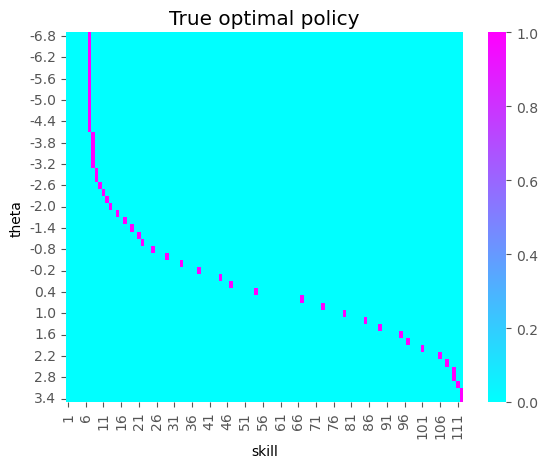

In [41]:
sns.heatmap(mat_opt.astype(float),cmap='cool')
plt.title('True optimal policy')
plt.ylabel('theta')
plt.xlabel('skill')


We can calculate the real value of our policy and see how it compares with our estimation

In [56]:
policy_value_of_ipw=np.average(bdf_feedback_test["expected_reward"], weights=eval_policy_dist[:, :, 0], axis=1).mean()


In [61]:
 squared_errors = ope.evaluate_performance_of_estimators(
            ground_truth_policy_value=policy_value_of_ipw, # V(\pi_e)
            action_dist=eval_policy_dist, # \pi_e(a|x)
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model, # \hat{q}(x,a)
            metric="se", # squared error
        )

In [62]:
squared_errors

{'ipw': 42.456893745384235, 'dm': 44.71629932803568, 'dr': 44.24216234929811}

In [63]:
  from obp.ope import KernelizedInverseProbabilityWeighting

In [72]:
kipw=KernelizedInverseProbabilityWeighting(kernel='gaussian',bandwidth=3.0)

In [75]:
kipw.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action_by_behavior_policy=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_by_evaluation_policy=eval_policy_rf_dist.argmax(1).reshape(len(bdf_feedback_test['context']),).astype(float))

4.599084886712872

array([84, 84, 83, ..., 81, 84, 84])

0